In [ ]:
import pandas as pd
import numpy as np
import scipy.signal as signal
from scipy.signal import find_peaks, butter, filtfilt

import matplotlib.pyplot as plt
import pickle

# File path to the pickle file
derivative_folder = '/content/drive/MyDrive/Project Psychophysiology/spider/preprocessed-data/'
output_filename = derivative_folder + 'preprocessed_eda.pkl'

# Load the pickle file
with open(output_filename, 'rb') as f:
    loaded_data = pickle.load(f)
    print(len(loaded_data))
    print(type(loaded_data))

 # Display the loaded data
print(loaded_data[0])

9
<class 'list'>
{'participant': 'sub-1', 'condition': 'baseline', 'data':         # EDA
0       383.0
1       383.0
2       383.0
3       383.0
4       383.0
...       ...
176995  229.0
176996  230.0
176997  230.0
176998  229.0
176999  229.0

[177000 rows x 1 columns]}


Participant: sub-1, Condition: baseline
[-0.00101744 -0.00098881 -0.00095839 -0.00092617 -0.00089213 -0.00085625
 -0.00081852 -0.00077894 -0.00073747 -0.00069413]


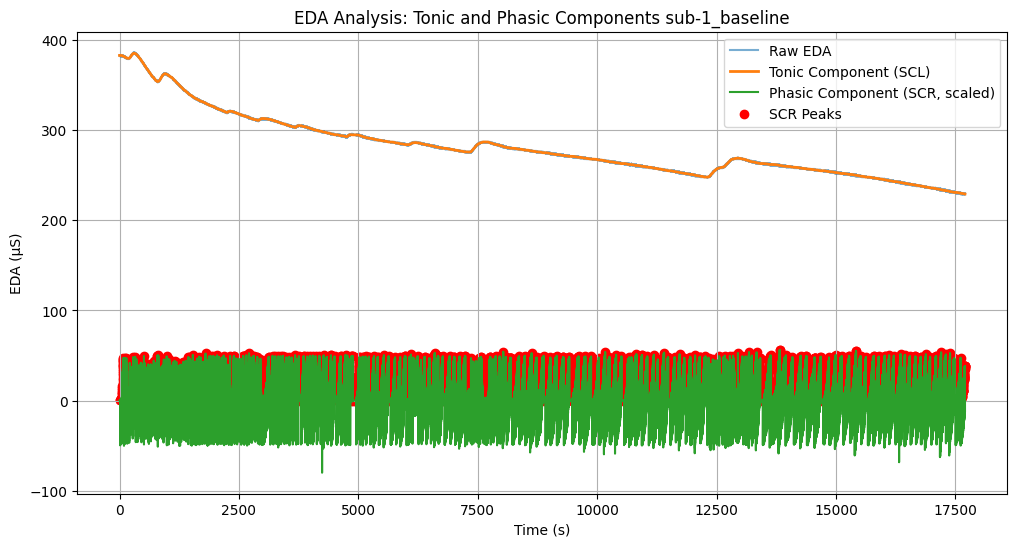

Participant: sub-1, Condition: spiderhand
[-0.01960383 -0.0195911  -0.0195589  -0.01950684 -0.01943452 -0.01934156
 -0.0192276  -0.01909229 -0.0189353  -0.01875631]


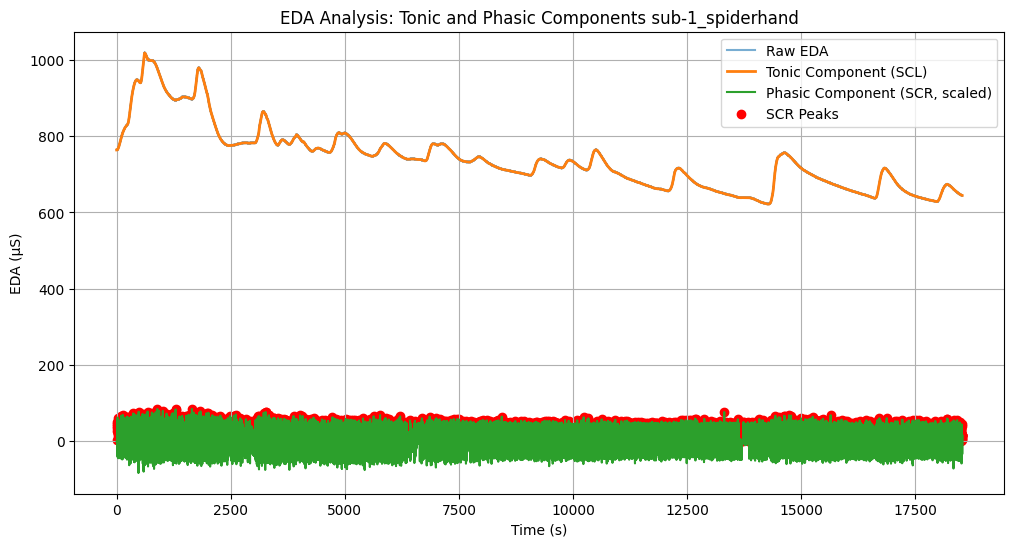

Participant: sub-1, Condition: spidervideo
[-0.03120406 -0.03194033 -0.03265849 -0.03335718 -0.03403504 -0.03469067
 -0.03532266 -0.03592958 -0.03650998 -0.03706239]


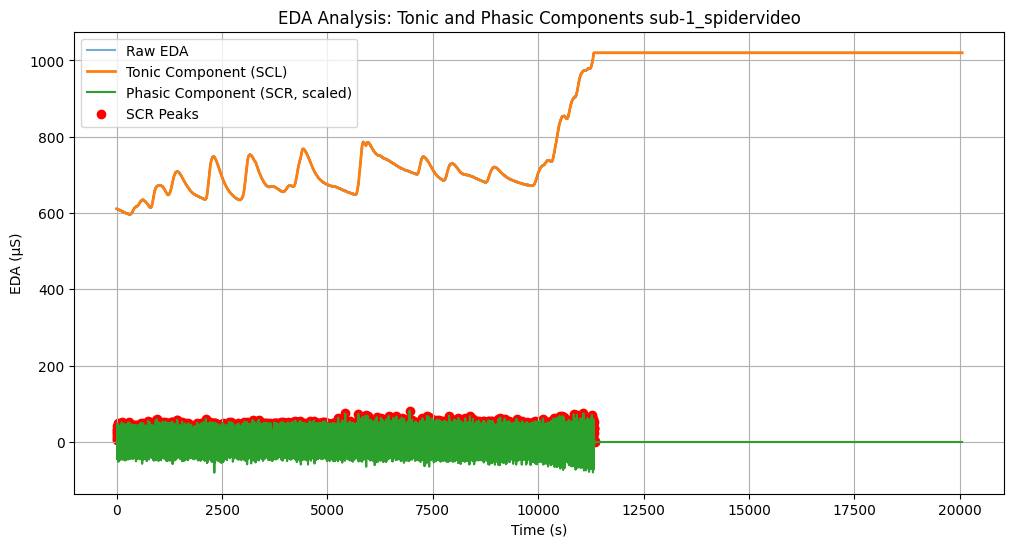

Participant: sub-2, Condition: baseline
[-0.03739715 -0.06887102 -0.10074318 -0.13300956 -0.16566594 -0.19870798
 -0.23213119 -0.26593095 -0.30010251  0.665359  ]


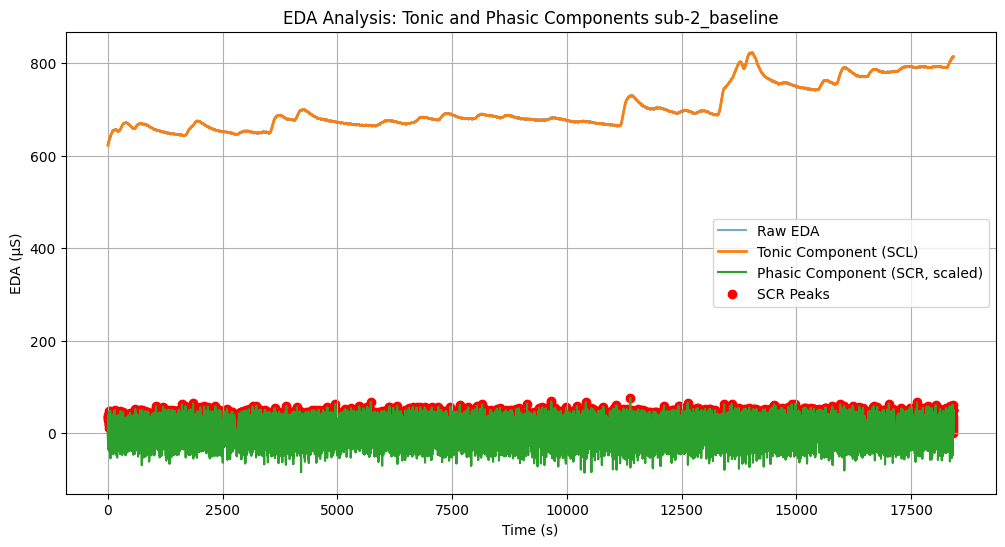

Participant: sub-2, Condition: spiderhand
[0.00344518 0.00372127 0.00400017 0.00428167 0.00456554 0.00485155
 0.00513946 0.00542903 0.00572001 0.00601213]


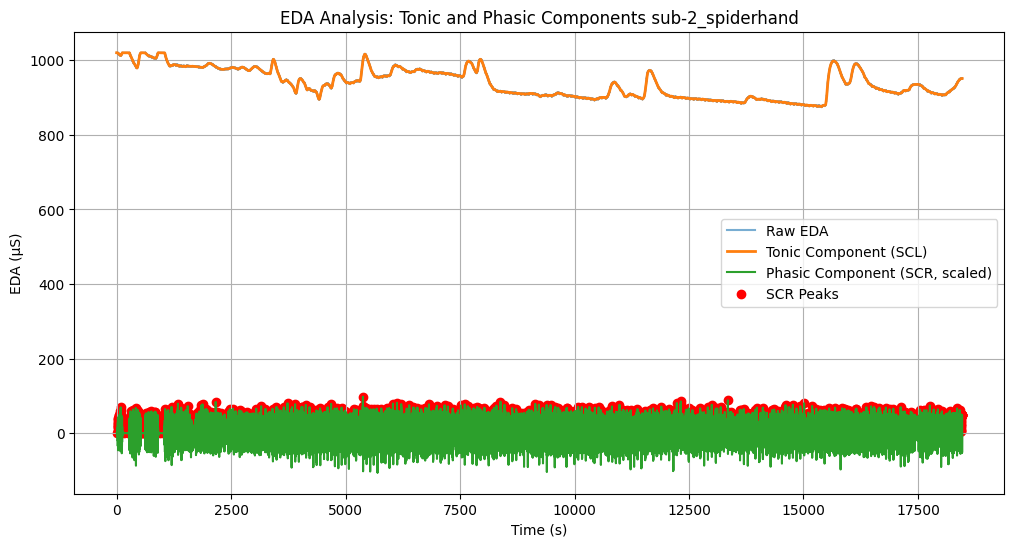

Participant: sub-2, Condition: spidervideo
[-0.01196669 -0.01233394 -0.01270082 -1.01306712 -0.01343261 -0.01379705
 -1.01416023 -0.01452191 -0.01488186  0.98476013]


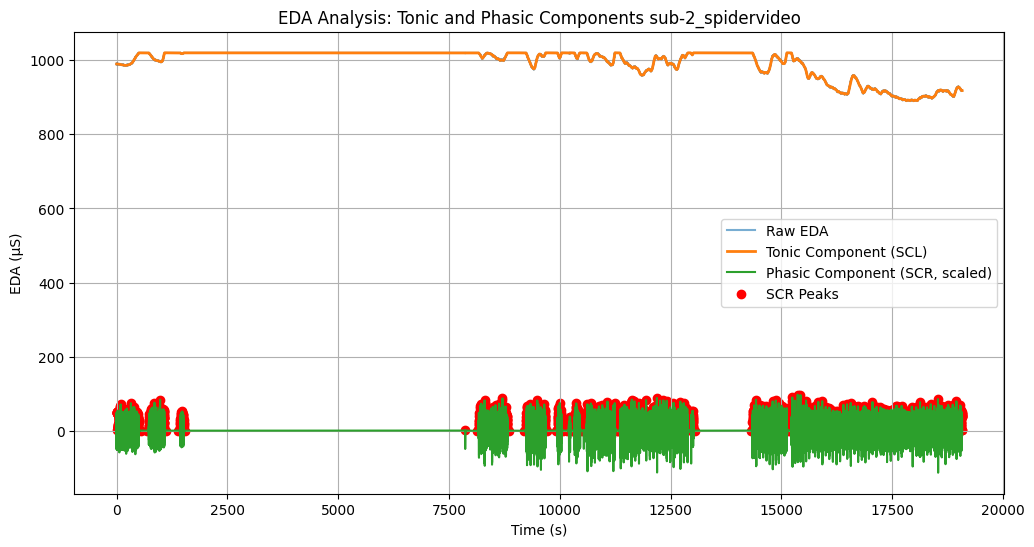

Participant: sub-3, Condition: baseline
[ 0.0277405  -0.97207383  0.02808939  0.02822943  0.02834556  0.02843702
 -0.9714969   0.02854307  0.02855621  0.02854179]


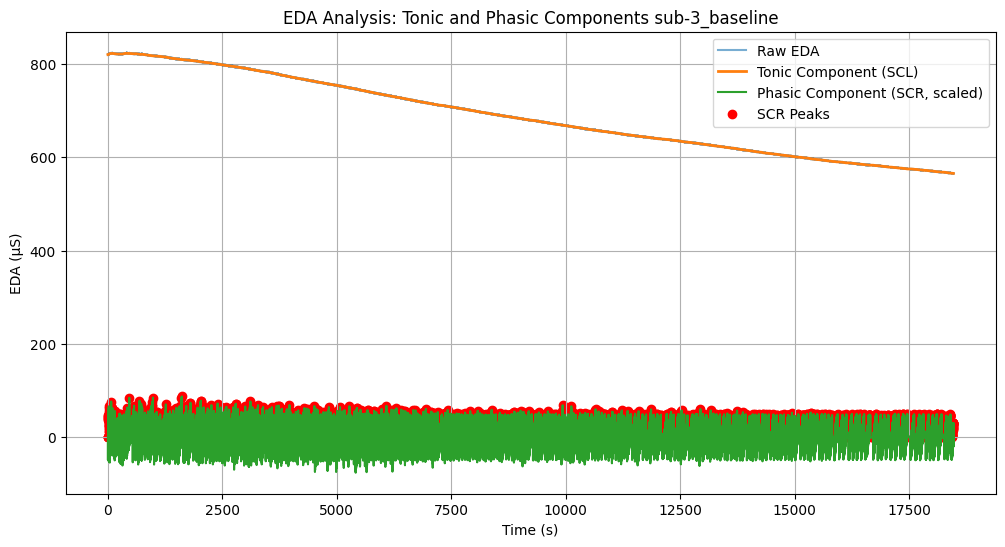

Participant: sub-3, Condition: spiderhand
[-0.02982805 -0.00305888  0.02397426  0.05126592  0.07881056  0.1066025
  0.13463597  0.1629051   0.19140388  0.22012625]


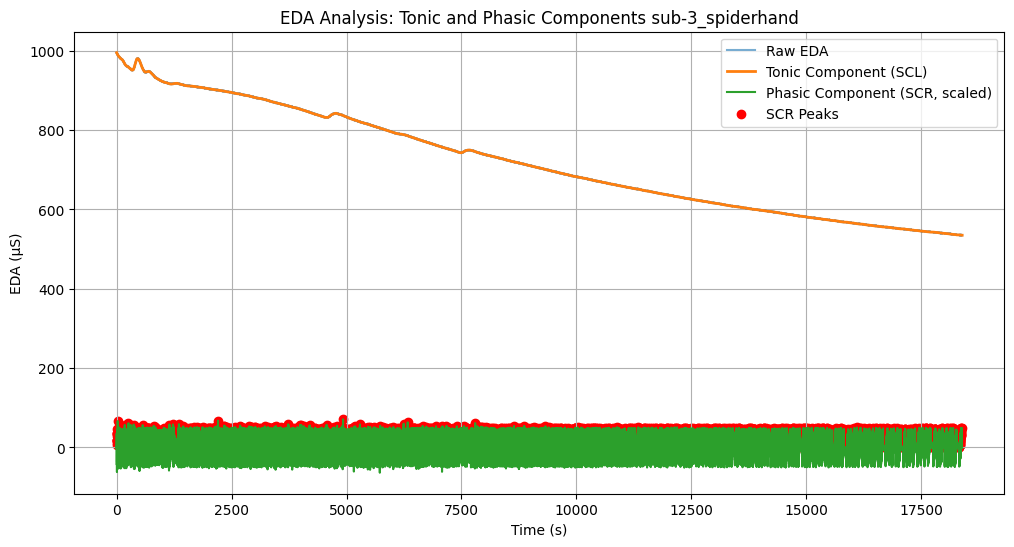

Participant: sub-3, Condition: spidervideo
[0.01083166 0.01234712 0.01389889 0.01548678 0.01711055 0.01876993
 0.02046466 0.02219441 0.02395884 0.0257576 ]


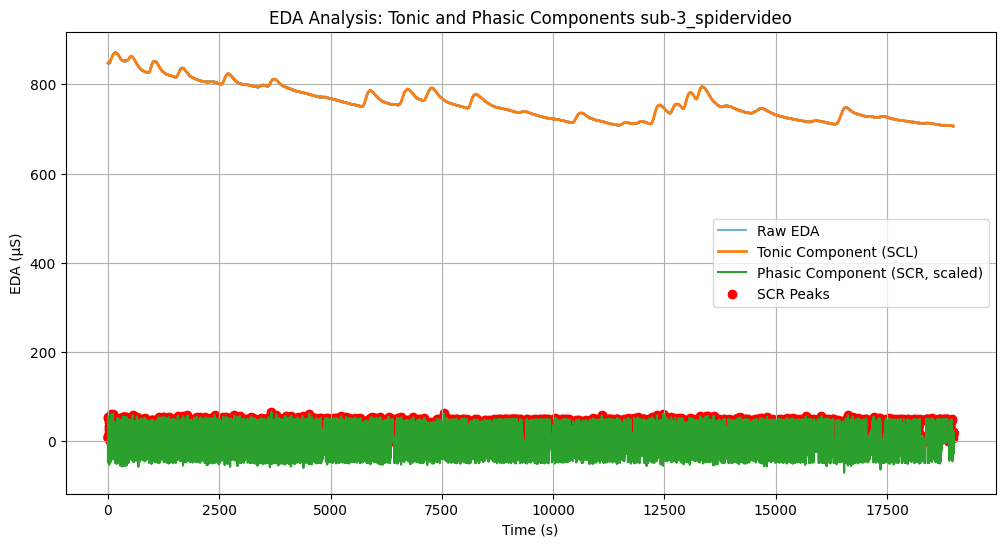

In [ ]:
# iterate over all data within loaded_data
for participant_data in loaded_data:
    participant = participant_data['participant']
    condition = participant_data['condition']

    eda_datafr = participant_data['data'].dropna()



    print(f"Participant: {participant}, Condition: {condition}")


    eda_data = eda_datafr.values.flatten()

    sampling_frequency = 10  # Downsampled to 10 Hz
    time = np.arange(len(eda_data)) / sampling_frequency

    # 1. Extract the Tonic Component (SCL) using low-pass filtering
    def low_pass_filter(data, cutoff, fs, order=4):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)

        return filtfilt(b, a, data)

    cutoff_frequency = 0.05  # Cutoff for tonic (very slow changes)
    tonic_component = low_pass_filter(eda_data, cutoff_frequency, sampling_frequency)

    # 2. Extract the Phasic Component (SCR) by subtracting the tonic from the original
    phasic_component = eda_data - tonic_component
    print(phasic_component[:10])
    scaling_factor = 50
    scaled_phasic_component = phasic_component * scaling_factor



    # Detect SCR peaks in the phasic component
    peak_threshold = 0.02
    peaks, _ = find_peaks(scaled_phasic_component, height=peak_threshold, distance=sampling_frequency)

    # Compute SCR amplitude (height of detected peaks)
    scr_amplitudes = scaled_phasic_component[peaks]

    # Visualize the results
    plt.figure(figsize=(12, 6))
    plt.plot(time, eda_data, label="Raw EDA", alpha=0.6)
    plt.plot(time, tonic_component, label="Tonic Component (SCL)", linewidth=2)
    plt.plot(time, scaled_phasic_component, label="Phasic Component (SCR, scaled)",)
    #plt.plot(time, phasic_component, label="Phasic Component (SCR)", alpha=0.8)
    plt.scatter(peaks / sampling_frequency, scr_amplitudes, color="red", label="SCR Peaks")
    plt.xlabel("Time (s)")
    plt.ylabel("EDA (µS)")
    plt.title("EDA Analysis: Tonic and Phasic Components " + participant + "_" + condition)
    plt.legend()
    plt.grid(True)
    plt.show()